In [20]:
from gurobipy import *
from math import factorial
import pandas as pd
import time
import numpy as np
from matplotlib import pyplot as plt

### Parameters setting

In [21]:
coord = {}
n_seats = 188

# Defines the coordinates of each seat
for i in range(1,n_seats+1):
    if i < 33:
        coord[i] = [1,i]
    elif i < 65:
        coord[i] = [2,i-32]
    elif i < 96:
        coord[i] = [3,i-64]
    elif i < 127:
        coord[i] = [5,i-95]
    elif i < 158:
        coord[i] = [6,i-126]
    elif i < 189:
        coord[i] = [7,i-157]
        
# Calculates the Manhattan distance between seats
d = {}
for i in range(1,n_seats+1):
    for j in range(1,n_seats+1):
        d[i,j] = abs(coord[i][0] - coord[j][0]) + abs(coord[i][1]-coord[j][1])
    
    
# Imports data from Excel file and drops Nan
# (Only the data of bought seats is used)
df = pd.read_excel (r'BD SEAT .xlsx').dropna()


# Retrieves the seat most times purchased
maximo = max(df['UnitDesignator'].value_counts())

# Rank 
normalizado = df['UnitDesignator'].value_counts()/maximo


# Seats are encoded by 1A, 1B,... to 1, 2, ...
vec = {}
for i in range(0, len(normalizado.index)):
    if len(normalizado.index[i]) == 2 :
        if normalizado.index[i][-1] == 'A':
            vec[int(normalizado.index[i][0])] = 1
        elif normalizado.index[i][-1] == 'B':
            vec[int(normalizado.index[i][0])+32] = 1
        elif normalizado.index[i][-1] == 'C':
            vec[int(normalizado.index[i][0])+32+32] = 1
        elif normalizado.index[i][-1] == 'D':
            vec[int(normalizado.index[i][0])+32+32+31] = 1
        elif normalizado.index[i][-1] == 'E':
            vec[int(normalizado.index[i][0])+32+32+31+31] = 1
        elif normalizado.index[i][-1] == 'F':
            vec[int(normalizado.index[i][0])+32+32+31+31+31] = 1
            
    elif len(normalizado.index[i]) == 3 :
        if normalizado.index[i][-1] == 'A':
            vec[int(normalizado.index[i][0:2])] = 1
        elif normalizado.index[i][-1] == 'B':
            vec[int(normalizado.index[i][0:2])+32] = 1
        elif normalizado.index[i][-1] == 'C':
            vec[int(normalizado.index[i][0:2])+32+32] = 1
        elif normalizado.index[i][-1] == 'D':
            vec[int(normalizado.index[i][0:2])+32+32+31] = 1
        elif normalizado.index[i][-1] == 'E':
            vec[int(normalizado.index[i][0:2])+32+32+31+31] = 1
        elif normalizado.index[i][-1] == 'F':
            vec[int(normalizado.index[i][0:2])+32+32+31+31+31] = 1

# Sets rank to each seat            
contador = -1
for i in vec.keys():
    contador += 1
    vec[i] = normalizado.values[contador]

    

# Minimum distance parameter
beta = {}

# Minimum distance
min_dist = 7 # change to 0 if minimising seat's distance
delta = min_dist

# Percentage of blocked seats
ghost_percentage = 0.82


flightCounter = 0

# Objective cost
costo_objetivo = []

# Objective distance
distancia_objetivo = []



df = pd.read_excel (r'BD SEAT .xlsx')
df['BookingBookDate']= pd.to_datetime(df['BookingBookDate'])
df = df[df['SeatBookDateTime'].isnull()]
dep = df['DepartureDate']
depDates = df['DepartureDate'].unique()

In [22]:
I = range(1, n_seats + 1)

c = {}
a = {}
for i in I:
    a[i] = 1
    
vecc = [39,34,34,34,34,27,27,27,27,27,27,29,29,18,18,18,18,18,18,18,18,18,18,14,14,14,14,14,14,14,14,14]
vec2 = [34,29,29,29,29,22,22,22,22,22,22,24,24,12,12,12,12,12,12,12,12,12,12,9,9,9,9,9,9,9,9,9]


for i in range(0,32):
    c[i+1] = vecc[i]
    c[i+33] = vec2[i]
    if i != 31:
        c[i+65] = vecc[i]
        c[i+96] = vecc[i]
        c[i+127] = vec2[i]
        c[i+158] = vecc[i]


costoReal = c.copy()

bono = 100
for i in c:
    if i != 32:
        c[i] = c[i] + bono*vec[i]

c[32] = 500
c[64] = 500
c[31] = 500
c[63] = 500
c[95] = 500
c[126] = 500
c[157] = 500
c[188] = 500
c[31] = 500
c[62] = 500
c[94] = 500
c[125] = 500   
c[156] = 500
c[187] = 500  

# Optimisation model function

In [23]:
def optimisation(q):    
        
    m = Model("Proyecto: "+str(t))
    m.setParam("OutputFlag",0)
    
    
    w1 = 1.8
    w2 = -1.5
    
    
    # Decision variables
    x = {(i):m.addVar(vtype=GRB.BINARY, obj = w1*c[i], name="x"+str(i)) for i in I}
    y = {(i,j):m.addVar(vtype=GRB.BINARY, obj = w2*d[i,j], name="y"+str(i)+str(j)) for i in I for j in I if j!=i}



    # Constraints
    for i in I:
        

        # Constraints (5)
        m.addConstr(x[i] <= a[i])
        
        # Constraints (3) and (4)
        m.addConstr(quicksum(y[i,m] for m in I if m!=i) - x[i]*(q-1) == 0)
        m.addConstr(quicksum(y[m,i] for m in I if m!=i) - x[i]*(q-1) == 0)


    # Constraint (2)
    m.addConstr(quicksum(x[i] for i in I) == q)



    if q >= 10:

        m.setParam('SolutionLimit', 1)
        m.setParam('MIPGap', 0.2)
        

        
        for i in I:
            for j in I:
                if d[i,j] >= delta:
                    beta[i,j] = 1
                else:
                    beta[i,j] = 0  

    elif q < 10 and q >= 7: 

        m.setParam('MIPGap', 0.15)
        
        
        for i in I:
            for j in I:
                if d[i,j] >= delta:
                    beta[i,j] = 1
                else:
                    beta[i,j] = 0  

    elif q < 7:

        m.setParam('MIPGap', 0.05)
        

        
        for i in I:
            for j in I:
                if d[i,j] >= delta:
                    beta[i,j] = 1
                else:
                    beta[i,j] = 0  

    for i in I:
            for j in I:
                if i!=j:
                    # Constraints (6)
                    m.addConstr(y[i,j] <= beta[i,j])
                    

    
    m.ModelSense = 1 # Minimising

    
    m.setParam('Heuristics', 0)
    m.setParam('Threads', 8)
    m.setParam("DualReductions",0)
    m.setParam("InfUnbdInfo", 1)
    
    
    m.update()

    m.optimize()
    
    if m.Status == 2:
        return m.objVal, x, y, m.Status, m
    if m.Status == 3:
        return 'inf', x, y, m.Status, m

# Algorithm 

In [24]:
for dep_date in depDates[0:1]:
    
    dep_df = df[df['DepartureDate'] == dep_date]
    NumberFlights = dep_df['FlightNumber'].unique()

    
    for number_flight in NumberFlights[5:6]:
        
        number_df = dep_df[dep_df['FlightNumber'] == number_flight]
        
        fec = pd.DataFrame(number_df['BookingBookDate'].value_counts())
        fec['Date'] = fec.index
        qReal = fec.sort_values(by='Date', ascending=True)['BookingBookDate']
        
        flightCounter += 1
        
        
        qR = []
        for i in qReal:
            qR.append(i)
            
            
        #### Parametro para porcentaje de sillas ocupadas inicialmente
        
        sortedC = dict(sorted(c.items(), key=lambda x:x[1]))

        cntr = 0
        indexes = []
        for i in reversed(sortedC):
            if cntr <= len(c)*ghost_percentage-1:
                a[i] = 0
                indexes.append(i)
            cntr += 1
        indexes = list(reversed(indexes))           
            
 

        #### Empieza a optimizar
        
        seats = {}
        tInicial = time.time()
        
        iter_time = {}
        t = 0
        iter_OF = {}
        counter_ = 0
        
        
        superCounter = 0
        while sum(a.values()) > 0:
            t_Iter = time.time()
            
            
            if len(qR) - t <= 0:
                break
            
            
            t += 1
            
            breakVar = 0
            while qR[t-1] >= 20:
                t += 1
                if len(qR) - t <= 0:
                    breakVar = 1
                    break
            if breakVar == 1:
                break
                
            q = qR[t-1]  
            q = 4
            
            OF, x, y, m_status, m = optimisation(q)
            
            if m_status == 3 and delta > 0:
                
                t -= 1
                
                delta -= 1
                
                for i in range(1, n_seats + 1):
                    for j in range(1, n_seats + 1):
                        if d[i,j] >= delta:
                            beta[i,j] = 1
                        else:
                            beta[i,j] = 0
                            
            elif m_status == 3 and delta <= 0:
                break
            else:
                iter_time[t] = round(time.time() - t_Iter, 4)
                iter_OF[t] = OF
                #print(iter_time[t])
                
                distancia_objetivo.append(sum(y[i,j].X*(d[i,j]) for i in I for j in I if i!=j))
                costo_objetivo.append(sum(x[i].X*c[i] for i in I))

                delta = min_dist
                
                
                
                
                vals = { k : v.X for k,v in x.items() }
                for b in vals:
                    if vals[b] > 0.5:
                        a[b] = 0
                        seats[b] = t

                if superCounter <= len(indexes):
                    for i in indexes[superCounter:superCounter + q]:
                        a[i] = 1


                    superCounter += q
    
        tTotal = round(time.time() - tInicial,5) 

Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap to value 0.05
Set parameter MIPGap

In [25]:
timee = iter_time
OFS = iter_OF

In [17]:
timee_no_ghosts = iter_time
OFS_no_ghosts = iter_OF

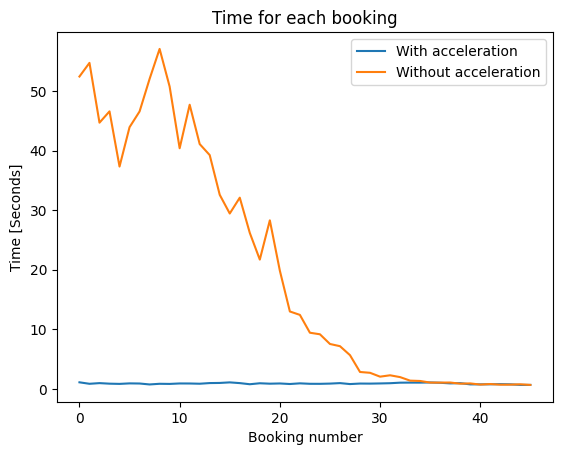

In [26]:
plt.xlabel("Booking number")
plt.ylabel("Time [Seconds]")
plt.title('Time for each booking')
plt.plot(timee.values(), label = 'With acceleration')
plt.plot(timee_no_ghosts.values(), label = 'Without acceleration')
plt.legend()

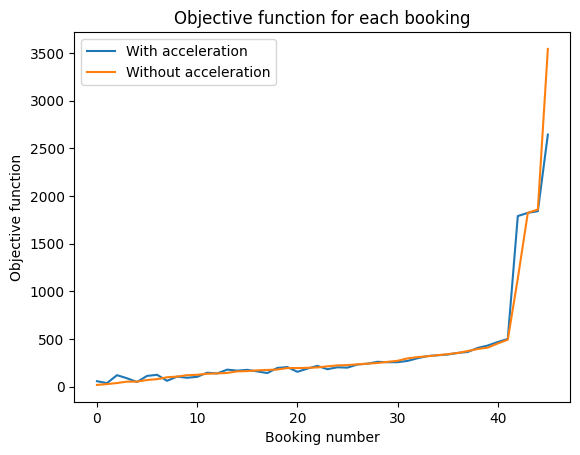

In [27]:
plt.xlabel("Booking number")
plt.ylabel("Objective function")
plt.title('Objective function for each booking')
plt.plot(OFS.values(), label = 'With acceleration')
plt.plot(OFS_no_ghosts.values(), label = 'Without acceleration')
plt.legend()

In [29]:
len(OFS_no_ghosts)

46